In [1]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils as utils
import torch.optim as optim
import torchvision
import torch.utils.data as data
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
class fewShotDataset(data.Dataset):
  def __init__(self, indices, parent):
    self.indices = indices
    self.parent = parent
  
  def __len__(self):
    return len(self.indices)
  
  def __getitem__(self, idx):
    index = self.indices[idx]
    return self.parent.__getitem__(index)

In [3]:

class OMM(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.num_classes = num_classes
    self.conv = nn.Sequential(
        # 105 x 105 - 1
        nn.Conv2d(1, 64, 7, 2, 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        # 51 x 51 - 64
        nn.Conv2d(64, 64, 5, 2, 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        # 25 x 25 - 64
        nn.Conv2d(64, 64, 3, 2, 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        # 14 x 14 - 64
        nn.Conv2d(64, 64, 3, 2, 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        # 7 x 7 - 64
        nn.Conv2d(64, 64, 3, 2, 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        # 4 x 4 - 64
        nn.Conv2d(64, 64, 3, 2, 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        # 2 x 2 - 64
    )

    self.linear = nn.Linear(256, self.num_classes)

    self.prob = nn.Softmax()

    self.loss = nn.CrossEntropyLoss()
  
  def Forward(self, X: torch.Tensor):
    if not X.is_cuda:
      X = X.cuda()
    X = X.view(-1, 1, 105, 105)
    X = self.conv(X)
    X = X.view(-1, 256)
    X = self.linear(X)
    X = self.prob(X)
    _, pred = X.max(1)
    return X, pred

  

In [ ]:
class REPTILE:
  def __init__(self, model: nn.module, dataset: data.Dataset, optim: torch.optim):
    self.model = model
    self.metaModel = model
    self.dataset = dataset
    self.optim = optim
    self.iteration = 0

  def getNext(self):
    while True:
      for x in self.dataset:
        yield x
  
  @staticmethod
  def selectTraining_Test(K_shots=1, N=5, test_shot = 1):
  #some hard coding used, 20 samples per script, 964 total scripts
    clases = np.random.choice(964, N, replace=False) * 20 #indices
    sample = np.array([np.random.choice(16, K_shots, replace=False) for i in range(N)])
    test = np.array([np.random.choice([16, 20], test_shot, replace=False) for i in range(N)])
    sample = sample.reshape((-1, N))
    test = test.reshape((-1, N))
    train = (sample + clases).flatten()
    test = (test + clases).flatten()
    return train, test
  
  def step(self):
    return

In [4]:
def train(dataIter, model, optimizer, iterations=1000):
  #does SGD with one dataset at once
    model.train()
    for iteration in range(iterations):
        X, y = next(dataIter)
        X, y = X.cuda(), y.cuda()
        pred, _ = model.Forward(X)
        loss = model.loss(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        """
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            """

In [5]:
def evaluate(dataIter, model, loss_fn, testIt):
    model.eval()
    losses, accuracies = [], []
    for iteration in range(testIt):
        data, labels = next(dataIter)
        data, labels = data.cuda(), labels.cuda()
        prediction, argmax = model.Forward(data)

        # Get softmax loss
        loss = model.loss(prediction, labels)

        # Get accuracy (note: this is still comparing 1 label, used this for convenience sake for loss)
        accuracy = (argmax == labels).float().mean()

        losses.append(loss.item())
        accuracies.append(accuracy.item())

    return np.mean(losses), np.mean(accuracies)

In [6]:
valid_test_transform = transforms.Compose(
    [
        transforms.ToTensor(),   # convert image to PyTorch Tensor
        # normalize to [-1.0, 1.0] (originally [0.0, 1.0])
    ]
)

train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

ds = datasets.Omniglot(
    root = "Data",
    download = True,
    transform = train_transform
)

print(ds.__len__())
#Gen = torch.Generator().manual_seed(189)

#train, test = data.random_split(ds, [0.8, 0.2], Gen)



100%|██████████| 9464212/9464212 [00:00<00:00, 95155158.34it/s]

Extracting Data/omniglot-py/images_background.zip to Data/omniglot-py


19280


In [7]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(img.shape)
    plt.imshow(npimg)
    plt.show()


#print(train.__len__())
#print(test.__len__())
#20 per script, set away the last 4 as validation
"""
for i in range(20, 40):
  print(i)
  image, labels = ds.__getitem__(i)
  # show images
  print(labels)
  imshow(torchvision.utils.make_grid(image))
"""

'\nfor i in range(20, 40):\n  print(i)\n  image, labels = ds.__getitem__(i)\n  # show images\n  print(labels)\n  imshow(torchvision.utils.make_grid(image))\n'

In [11]:
innerLR = 0.001
outerLR = 0.5
innerIt = 10
totIt = 50000
batch_size = 10
num_shots = 2
evalIt = 1000 #evaluate every 1000 steps
N = 5
num_classes = 964
model = OMM(num_classes)
metaModel = OMM(num_classes)
model.cuda()
metaModel.cuda()
optimInner = torch.optim.Adam(model.parameters(), innerLR, betas = (0, 0.999)) #for normal ConvNet training
optimMeta = torch.optim.SGD(model.parameters(), outerLR, momentum = 0.8)

In [9]:
def selectTraining_Test(K_shots=1, N=5, test_shot = 1):
  #some hard coding used, 20 samples per script, 964 total scripts
  clases = np.random.choice(964, N, replace=False) * 20 #indices
  sample = np.array([np.random.choice(16, K_shots, replace=False) for i in range(N)])
  test = np.array([np.random.choice([16, 20], test_shot, replace=False) for i in range(N)])
  sample = sample.reshape((-1, N))
  test = test.reshape((-1, N))
  train = (sample + clases).flatten()
  test = (test + clases).flatten()
  return train, test

def getNext(dataset):
  while True:
    for x in dataset:
      yield x


In [12]:
from torch.utils.data.dataloader import DataLoader

"""
trainData, _ = selectTraining_Test(2, 5, 2)
trainDataloader = DataLoader(ds, batch_size=10, sampler = trainData)
# in the case where the amount of selected data is less than 10, the batch will be that size instead of 10
K = getNext(trainDataloader)
for i in range(10):
  X, y = next(K)
  X = X[i].squeeze()
  print(y[i].item())
  imshow(X)
"""
acc = []

for metaIt in range(totIt + 1):
  metaLR = outerLR * (1 - metaIt/totIt)
  trainSet, _ = selectTraining_Test(num_shots, N, 2)
  trainDataloader = DataLoader(fewShotDataset(trainSet, ds), 10, True)
  trainDataloader = getNext(trainDataloader)
  currOptim = optimInner
  model.load_state_dict(metaModel.state_dict())
  train(trainDataloader, model, currOptim, innerIt)
  modelDict = model.state_dict()
  metaModel.load_state_dict({name: metaModel.state_dict()[name] + \
                             (modelDict[name] - metaModel.state_dict()[name])\
                             * metaLR for name in metaModel.state_dict().keys()})

  #eval phase
  if not metaIt % 1000 and metaIt:
    trainSet2, test2 = selectTraining_Test(num_shots, N, 2)
    trainSample = DataLoader(fewShotDataset(trainSet2, ds), 10, True)
    testDataloader = DataLoader(fewShotDataset(test2, ds), 10, True)

    # Convert into generators
    trainSample = getNext(trainSample)
    testDataloader = getNext(testDataloader)

    state = metaModel.state_dict()
    testModel = OMM(num_classes).cuda()
    testModel.load_state_dict(state)
    train(trainSample, testModel, optimInner, 20)
    loss, accuracy = evaluate(testDataloader, testModel, testModel.loss, 20)
    print(f"The loss on iteration {metaIt} is {loss}")
    print(f"The accuracy on iteration {metaIt} is {accuracy * 100}%")
    acc.append(accuracy * 100)

  



<ipython-input-3-2e681947501a>:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = self.prob(X)


The loss on iteration 1000 is 6.871419525146484
The accuracy on iteration 1000 is 0.0%
The loss on iteration 2000 is 6.719412779808044
The accuracy on iteration 2000 is 20.000000298023224%
The loss on iteration 3000 is 6.466122651100159
The accuracy on iteration 3000 is 50.0%
The loss on iteration 4000 is 6.709616994857788
The accuracy on iteration 4000 is 30.000001192092896%
The loss on iteration 5000 is 6.455261373519898
The accuracy on iteration 5000 is 40.00000059604645%
The loss on iteration 6000 is 6.772847247123718
The accuracy on iteration 6000 is 10.000000149011612%
The loss on iteration 7000 is 6.443010663986206
The accuracy on iteration 7000 is 40.00000059604645%
The loss on iteration 8000 is 6.473371982574463
The accuracy on iteration 8000 is 30.000001192092896%
The loss on iteration 9000 is 6.21303071975708
The accuracy on iteration 9000 is 60.00000238418579%
The loss on iteration 10000 is 6.1530961990356445
The accuracy on iteration 10000 is 69.9999988079071%
The loss on 

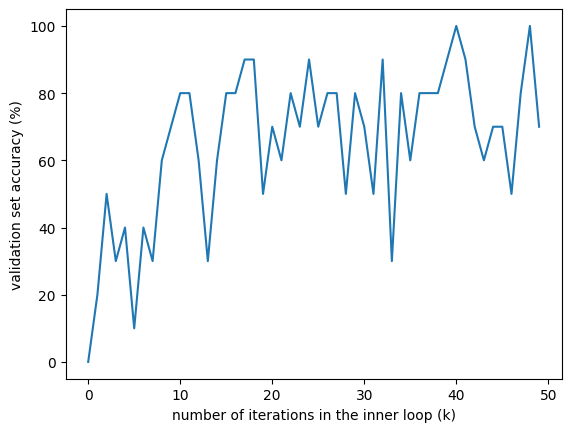

In [16]:
plt.plot(np.arange(totIt/1000), acc)
plt.xlabel("number of iterations in the inner loop (k)")
plt.ylabel("validation set accuracy (%)")
plt.show()